# AGS Example Notebook: Plot locations on a map and create a simple strip log from an AGS4 file

## 1. Import AGS4 data

We will use part of a publicly avaiable dataset provided by the British Geological Survey for this example. The name of the file is ***East West Rail BGS Pre October 2018 upload (partial).ags*** and a copy is included in this repo. The full file can be found at https://github.com/BritishGeologicalSurvey/pyagsapi/tree/main/test/files/real.

In [1]:
from python_ags4 import AGS4

tables, headings = AGS4.AGS4_to_dataframe('./East West Rail BGS Pre October 2018 upload (partial).ags')

## 2. Plot locations

All imported data is of the data type `str` so relevant numeric columns have to converted to `float` before they can be plotted. The following code converts the **LOCA** table to numeric data and plots the locations coordinates.

In [2]:
# Data types in imported LOCA table (first six columns only)
print("Imported LOCA data:\n")
display(tables['LOCA'].dtypes)

print("\nConverted LOCA data:\n")
LOCA = AGS4.convert_to_numeric(tables['LOCA'])

# Data types in converted LOCA tables (first six columns only)
display(LOCA.dtypes)

Imported LOCA data:



HEADING      object
LOCA_ID      object
LOCA_NATE    object
LOCA_NATN    object
dtype: object


Converted LOCA data:



HEADING       object
LOCA_ID       object
LOCA_NATE    float64
LOCA_NATN    float64
dtype: object

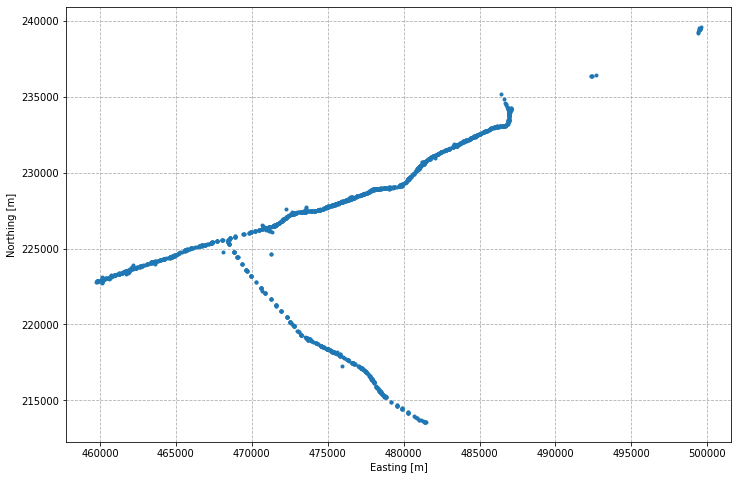

In [3]:
# NBVAL_SKIP
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(LOCA['LOCA_NATE'], LOCA['LOCA_NATN'], '.')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_aspect('equal', 'box')
ax.grid(ls='--')

This plot can be improved by adding a base map using the `contextily` package as shown below.

You can run `!pip install contextlily` in a new cell if the package is not already installed.

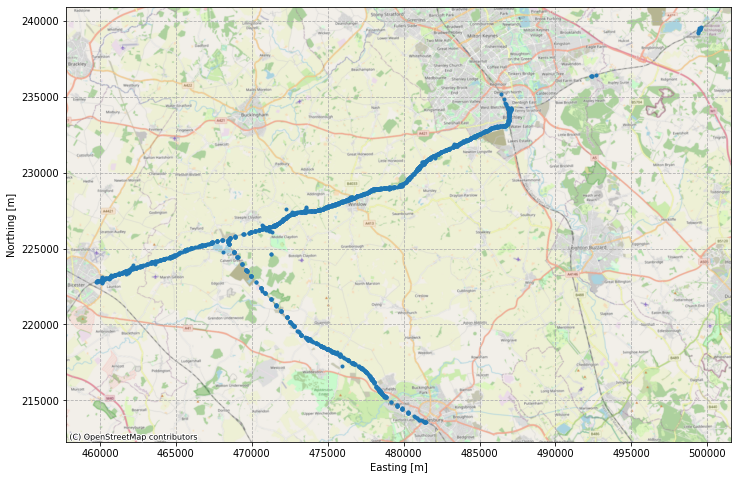

In [4]:
# NBVAL_SKIP
import contextily as cx

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(LOCA.LOCA_NATE, LOCA.LOCA_NATN, '.')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_aspect('equal', 'box')
ax.grid(ls='--')

# Add Basemap
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs='EPSG:27700', zoom=12)

## 3. Convert to geospatial data

The LOCA data which is currently in a Pandas DataFrame can be converted to a GeoDataFrame that provides additional functionality to perform geospatial operations. This requires the installation of the `geopandas` package with its many dependencies. The `geopandas` documentation strongly recommends installing the package using the `conda` package manager since it can be tricky to correctly install all the dependencies, especially in a Windows environment (https://geopandas.org/en/stable/getting_started/install.html).

In [5]:
# NBVAL_SKIP
import geopandas as gpd
from shapely.geometry import Point

geo_LOCA = LOCA.copy()
geo_LOCA['geometry'] = list(zip(geo_LOCA['LOCA_NATE'], geo_LOCA['LOCA_NATN']))
geo_LOCA['geometry'] = geo_LOCA['geometry'].apply(Point)
geo_LOCA = gpd.GeoDataFrame(geo_LOCA, geometry='geometry', crs='EPSG:27700')

geo_LOCA.head()

,HEADING,LOCA_ID,LOCA_NATE,LOCA_NATN,geometry
0,DATA,CP2A15CE,462741.00,223867.00,POINT (462741.000 223867.000)
1,DATA,CP2A15CW,462710.00,223859.00,POINT (462710.000 223859.000)
2,DATA,CP2A4C,468096.00,225585.00,POINT (468096.000 225585.000)
3,DATA,CP2ACLOB_1D,460162.80,222911.85,POINT (460162.800 222911.850)
4,DATA,CP2AGFFB_1U,460978.04,223222.96,POINT (460978.040 223222.960)


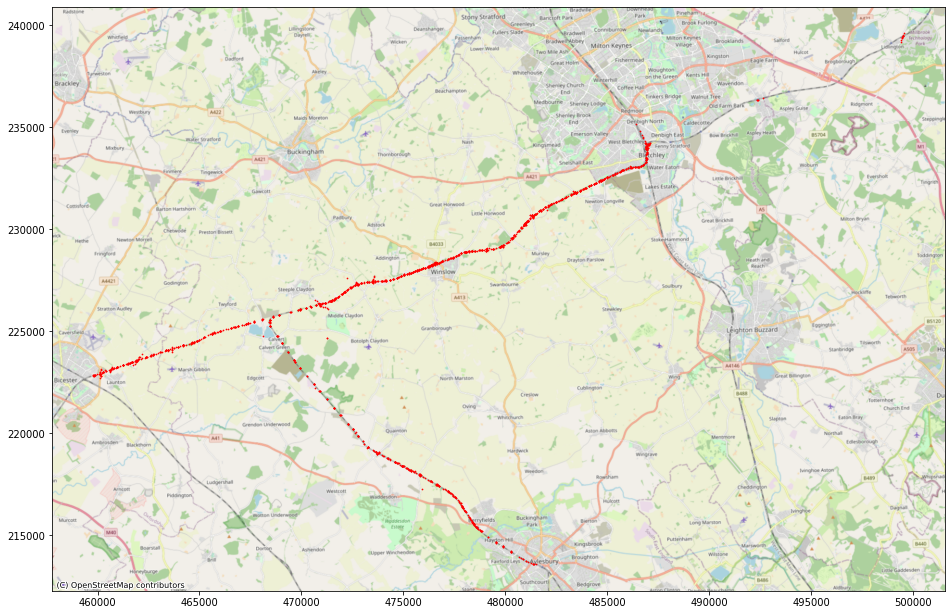

In [6]:
# NBVAL_SKIP
fig, ax = plt.subplots(figsize=(16, 20))

# Plot all boreholes
geo_LOCA.plot(markersize=0.5, color='red', ax=ax)

# Add Basemap
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs=geo_LOCA.crs.to_string(), zoom=12)

# Make figure aspect ratio ensure that 10x10 km square appears square
ax.set_aspect('equal', 'box')

## 4. Produce Strip Logs 

Here we extract intervals from the GEOL table and plot a basic strip log using https://github.com/agile-geoscience/striplog   

You can run `!pip install striplog` in a new cell if the package is not already installed.

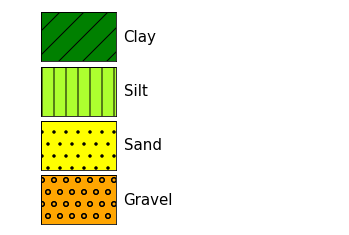

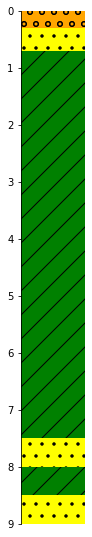

In [7]:
# NBVAL_SKIP
from striplog import Legend, Lexicon, Interval, Component, Striplog

# Create custom legend
l = u"""colour, component lithology, hatch
orange, GRAVEL, o
yellow, SAND, .
greenyellow, SILT, |
green, CLAY, /
"""
legend = Legend.from_csv(text=l)
legend.plot()

# Initiate list to store intervals/layers
intervals = []

# You will want a lexicon of some kind to interpret entries in GEOL_DESC
lexicon = Lexicon.default()

# Pick a location of interest and extract layer information from the GEOL table
GEOL = AGS4.convert_to_numeric(tables['GEOL'])

for row in GEOL.loc[GEOL.LOCA_ID.eq('CP2A15CE'), :].to_dict(orient='records'):
    interval = Interval(top=row['GEOL_TOP'], base=row['GEOL_BASE'], description=row['GEOL_DESC'], lexicon=lexicon)
    intervals.append(interval)
    
# Then make a striplog from the list:
slog = Striplog(list_of_Intervals=intervals) 

# Plot Lithology
slog.plot(ladder=True, aspect=5, ticks=1, legend=legend, match_only=['lithology'])